In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.pipeline import Pipeline

In [10]:
# Load the dataset
df = pd.read_csv('final_df.csv')

# Process MultiLabelBinarizer for specified columns
def process_multilabel_columns(df, columns):
    label_encoded_X = []
    mlb_list = []
    for col in columns:
        mlb = MultiLabelBinarizer()
        label_encoded = mlb.fit_transform(df[col])  # Ensure correct list handling
        label_encoded_X.append(label_encoded)
        mlb_list.append(mlb)
    return np.hstack(label_encoded_X), mlb_list

# Multi-label encoding
multi_label_columns = ['corrected_resource_type', 'corrected_subject_form', 'corrected_lang']
label_encoded_combined, mlb_list = process_multilabel_columns(df, multi_label_columns)

# Define numerical and categorical features
numerical_features = ['found_date', 'lat', 'lng']
categorical_features = []  # Add categorical columns if needed

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Apply preprocessing to numerical and categorical features
X_preprocessed = preprocessor.fit_transform(df[numerical_features + categorical_features])

# Combine preprocessed data with label-encoded data
X_combined = np.hstack((X_preprocessed, label_encoded_combined))

# Create final DataFrame with appropriate column names
final_df = pd.DataFrame(
    X_combined,
    columns=(
        preprocessor.get_feature_names_out().tolist() +
        [f"{col}_{cls}" for col, mlb in zip(multi_label_columns, mlb_list) for cls in mlb.classes_]
    )
)

final_df=final_df.sample(frac=1).reset_index(drop=True)


# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined[:20000])  # Use a subset for visualization


In [11]:

# Add t-SNE results to the DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['index'] = df.index[:20000]

# Scatter plot with interactive tooltips

tsne_df = tsne_df.merge(df[['found_date','corrected_resource_type', 'corrected_subject_form', 'corrected_lang', 'lat', 'lng', 'city_info']], left_on='index', right_index=True)
tsne_df['found_date'] = pd.to_datetime(tsne_df['found_date'], format='%Y', errors='coerce')

#tsne_df=tsne_df.dropna(subset=['found_date'])


In [12]:
fig = px.scatter(
    tsne_df,
    x='t-SNE 1',
    y='t-SNE 2',
   
    hover_data={
        'corrected_resource_type': True,

        'corrected_subject_form': True,
        'corrected_lang': True,
        'lat':True,
        'lng':True,
        'city_info':True,
        'index': False  # Hide index from tooltip
    },
    title="t-SNE Visualization of Custom Classification Dataset"
)

fig.update_layout(
    xaxis_title="First t-SNE Component",
    yaxis_title="Second t-SNE Component",
    hoverlabel=dict(bgcolor="white", font_size=12)
)

# Show interactive plot
fig.show()

<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

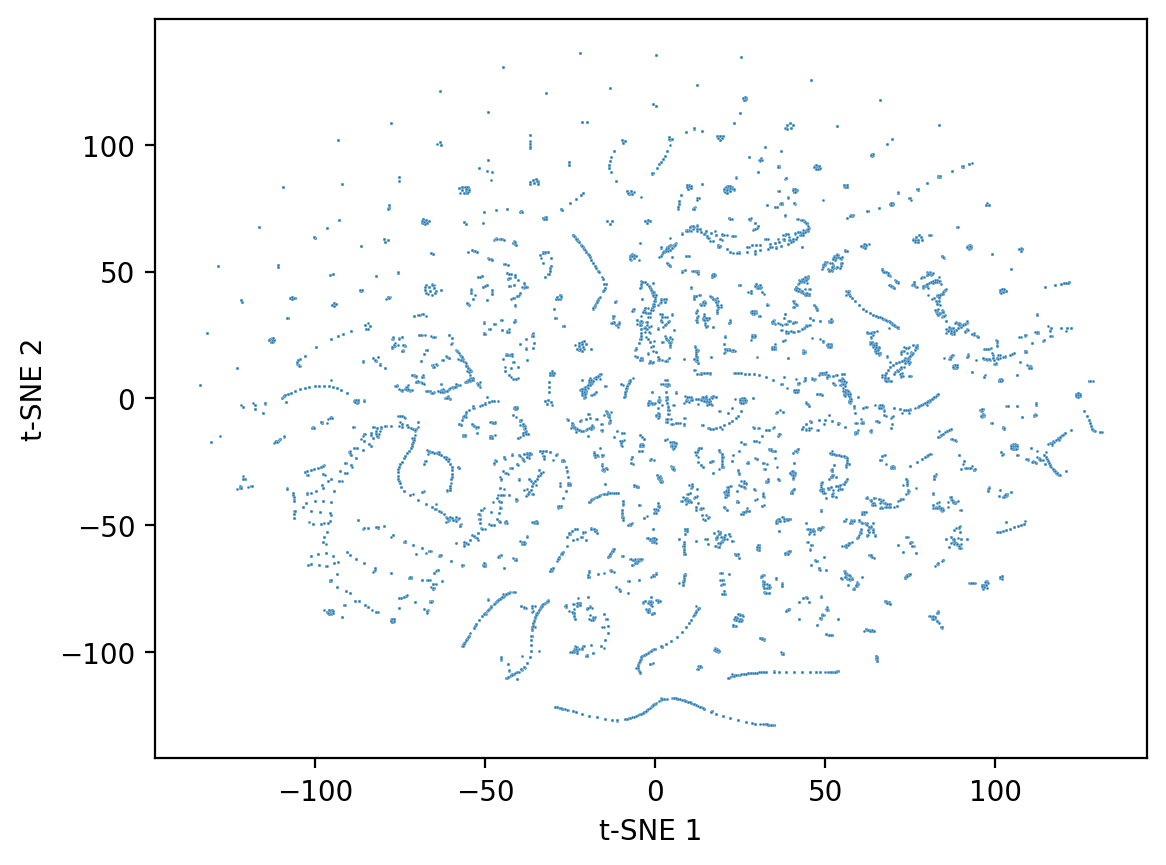

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax=plt.subplots(nrows=1, ncols=1, dpi=200)
sns.scatterplot(data=tsne_df, x='t-SNE 1', y='t-SNE 2', s=1)

In [3]:
!pip uninstall umap

^C


In [4]:
!pip install umap-learn